In [1]:
from functools import partial
import numpy as np
import os
import pandas as pd
import scipy

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt


import sys
sys.path.append('../')
import util

save_fig = partial(util.save_fig, save=True)

**Default parameters - will be replaced**

In [2]:
dataset_file = '/home/drake/workspace/em-2020/data/combined_dataset_subset_final.csv'
index_fields = ['Country', 'Year']
data_fields = ['ENI' ,'POP', 'URB', 'AFL' , 'TI', 'CTS' ,'KAOPEN']
prefix = 'template'
start_year = 1995
end_year = 2015
exclude_countries = []
pickle_file = '/home/drake/workspace/em-2020/analysis/D3_gmm/template_output.pickle.bz2'
pdynmc_params = {
    "use.mc.diff": True,
    "use.mc.lev": False,
    "use.mc.nonlin": False,
    "include.y": True,
    "varname.y": "ENI",
    "lagTerms.y": 2,
    "fur.con": True,
    "fur.con.diff": True,
    "fur.con.lev": False,
    "varname.reg.fur": ["POP", "AFL", "AFL2", "URB", "CTS", "TI", "KAOPEN"],
    "lagTerms.reg.fur": [0, 0, 0, 0, 0, 0, 0],
    "include.dum": True,
    "dum.diff": True,
    "dum.lev": False,
    "w.mat": "iid.err",
    "std.err": "corrected",
    "estimation": "twostep",
    "opt.meth": "none",
    "inst.stata": False,
}
plm_formula = 'ENI ~ lag(ENI, 1:2) + POP + AFL + AFL2 + URB + CTS + TI + KAOPEN | lag(ENI, 2:99)'
plm_params = {
    'effect': 'twoways',
    'model': 'twostep',
    'collapse': False,
    'transformation': 'd',
}

In [3]:
# Parameters
dataset_file = "/home/drake/workspace/em-2020/data/combined_dataset_subset_final.csv"
index_fields = ["Country", "Year"]
data_fields = ["ENI", "POP", "URB", "AFL", "TI", "TS", "CTS", "KAOPEN"]
prefix = "template"
start_year = 1995
end_year = 2015
exclude_countries = []
model_params = {
    "use.mc.diff": True,
    "use.mc.lev": False,
    "use.mc.nonlin": False,
    "include.y": True,
    "varname.y": "ENI",
    "lagTerms.y": 2,
    "fur.con": True,
    "fur.con.diff": True,
    "fur.con.lev": False,
    "varname.reg.fur": ["POP", "AFL", "AFL2", "URB", "CTS", "TI", "KAOPEN"],
    "lagTerms.reg.fur": [0, 0, 0, 0, 0, 0, 0],
    "include.dum": True,
    "dum.diff": True,
    "dum.lev": False,
    "w.mat": "iid.err",
    "std.err": "corrected",
    "estimation": "twostep",
    "opt.meth": "none",
    "inst.stata": False,
}
pdynmc_params = {
    "use.mc.diff": True,
    "use.mc.lev": False,
    "use.mc.nonlin": False,
    "include.y": True,
    "varname.y": "ENI",
    "lagTerms.y": 2,
    "fur.con": True,
    "fur.con.diff": True,
    "fur.con.lev": False,
    "varname.reg.fur": ["POP", "AFL", "AFL2", "URB", "CTS", "TI"],
    "lagTerms.reg.fur": [0, 0, 0, 0, 0, 0],
    "include.dum": True,
    "dum.diff": True,
    "dum.lev": False,
    "w.mat": "iid.err",
    "std.err": "corrected",
    "estimation": "twostep",
    "opt.meth": "none",
    "inst.stata": False,
}
pickle_file = "/home/drake/workspace/em-2020/analysis/D3_gmm/diffGMM_Rafiq2016-CTS-TI_subset.pickle.bz2"


**End of parameter section** 

In [4]:
%get dataset_file index_fields data_fields start_year end_year exclude_countries 
%get pdynmc_params plm_formula plm_params

# SoS mangles dict keys, for no apparent reason
names(pdynmc_params) <- gsub('_', '.', names(pdynmc_params))
names(plm_params) <- gsub('_', '.', names(plm_params))

suppressMessages({
library(dplyr)
library(plm)
library(pdynmc)
})
`%notin%` <- Negate(`%in%`)

data.df <- subset(
    read.csv(dataset_file), select=c(index_fields, data_fields),
    subset=(Country %notin% exclude_countries) 
    & (start_year <= Year) & (Year <= end_year)
)
data.df['AFL2'] = data.df['AFL']^2
data.panel <- pdata.frame(data.df, index = c("Country", "Year"), drop.index = TRUE, row.names=TRUE)

head(data.df %>% 
    group_by(Country) %>% 
    summarize(min=min(Year), max=max(Year), .groups='drop'))

Country,min,max
<fct>,<int>,<int>
ARG,1995,2014
AUS,1995,2015
BGR,1995,2014
BRA,1995,2014
CAN,1995,2015
CHE,1996,2014


In [5]:
pdynmc_params

$use.mc.diff
[1] TRUE

$use.mc.lev
[1] FALSE

$use.mc.nonlin
[1] FALSE

$include.y
[1] TRUE

$varname.y
[1] "ENI"

$lagTerms.y
[1] 2

$fur.con
[1] TRUE

$fur.con.diff
[1] TRUE

$fur.con.lev
[1] FALSE

$varname.reg.fur
[1] "POP"  "AFL"  "AFL2" "URB"  "CTS"  "TI"  

$lagTerms.reg.fur
[1] 0 0 0 0 0 0

$include.dum
[1] TRUE

$dum.diff
[1] TRUE

$dum.lev
[1] FALSE

$w.mat
[1] "iid.err"

$std.err
[1] "corrected"

$estimation
[1] "twostep"

$opt.meth
[1] "none"

$inst.stata
[1] FALSE

In [6]:
pdynmc_base_params <- list(dat = data.df, 
                    varname.i = "Country", varname.t = "Year", varname.dum = "Year")

pdynmc_fit <- do.call(pdynmc, modifyList(pdynmc_base_params, pdynmc_params))
pdynmc_summary <- summary(pdynmc_fit)
pdynmc_summary

Warning message in sqrt(diag(as.matrix(get(paste("step", j, sep = ""), resGMM.vcov.j)))):
“NaNs produced”



Dynamic linear panel estimation (twostep)
Estimation steps: 2

Coefficients:
          Estimate Std.Err.rob z-value.rob Pr(>|z.rob|)    
L1.ENI   0.1174077   0.0634740       1.850      0.06431 .  
L2.ENI   0.1329972   0.0719807       1.848      0.06460 .  
L0.POP  -0.0439330   0.0269219      -1.632      0.10268    
L0.AFL   0.0060582   0.0044498       1.361      0.17351    
L0.AFL2 -0.0297091   0.0070794      -4.197        3e-05 ***
L0.URB  -0.0214329   0.0134714      -1.591      0.11161    
L0.CTS  -0.0134232   0.0342120      -0.392      0.69506    
L0.TI    0.0131033          NA          NA           NA    
1998     0.0224434   0.0048442       4.633      < 2e-16 ***
1999     0.0103306          NA          NA           NA    
2000    -0.0025890          NA          NA           NA    
2001    -0.0089276          NA          NA           NA    
2002     0.0001376   0.0083183       0.017      0.98644    
2003     0.0082635   0.0123059       0.672      0.50158    
2004     0.0104133   0


Call:
lm(formula = residuals ~ fitted, data = pdynmc_resid)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.104342 -0.021494 -0.000403  0.020228  0.139481 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)   
(Intercept) -0.006676   0.002670  -2.500  0.01283 * 
fitted      -0.176474   0.057201  -3.085  0.00218 **
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.03292 on 385 degrees of freedom
  (9 observations deleted due to missingness)
Multiple R-squared:  0.02413,	Adjusted R-squared:  0.02159 
F-statistic: 9.518 on 1 and 385 DF,  p-value: 0.002181


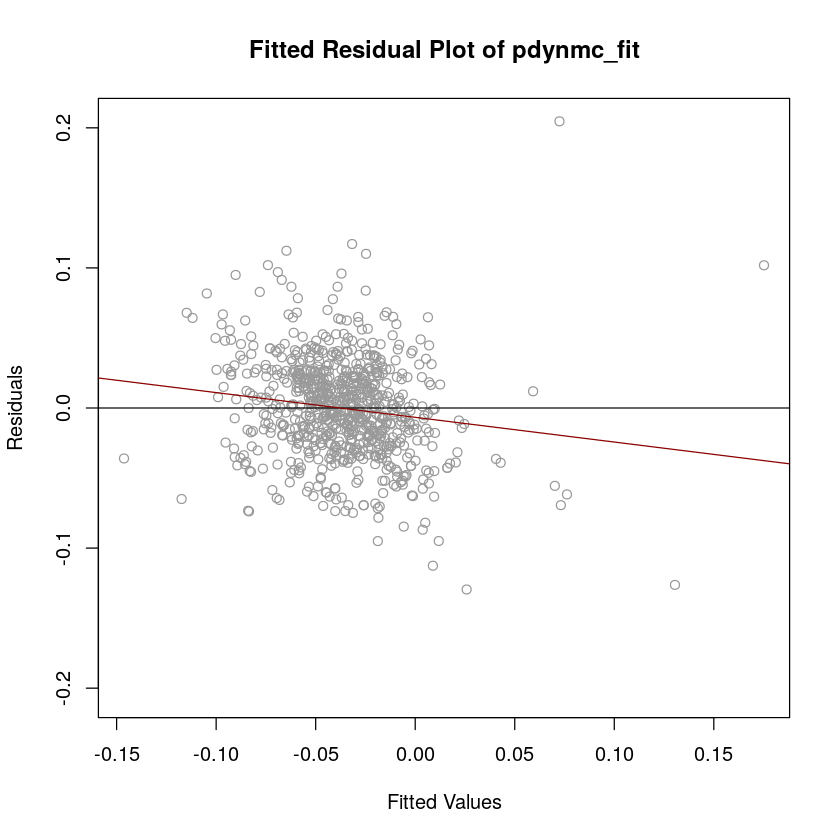

In [7]:
pdynmc_resid <- data.frame(residuals=unlist(residuals(pdynmc_fit)),
                           fitted=unlist(fitted.values(pdynmc_fit)))
resid.reg <- lm(residuals ~ fitted, data=pdynmc_resid)
plot(pdynmc_fit)
abline(resid.reg, col='darkred')
summary(resid.reg)

In [8]:
ser.corr1 <- mtest.fct(pdynmc_fit, t.order = 1)
ser.corr1
ser.corr2 <- mtest.fct(pdynmc_fit, t.order = 2)
ser.corr2


	Arrelano and Bond (1991) serial correlation test of degree 1

data:  2step GMM Estimation; H0: no serial correlation of order 1 in the error terms
normal = -1.3348, p-value = 0.1819



	Arrelano and Bond (1991) serial correlation test of degree 2

data:  2step GMM Estimation; H0: no serial correlation of order 2 in the error terms
normal = -1.0287, p-value = 0.3036


In [9]:
pdynmc_tests <- do.call(rbind, lapply(
    list(pdynmc_summary$hansenj, pdynmc_summary$slopef, pdynmc_summary$time.dumf, ser.corr1, ser.corr2),
    function(x) {
        data.frame(stat=as.numeric(x$statistic), test=names(x$statistic),
                   p.value=x$p.value, row.names=x$method, result=x$data.name)
    }
))
pdynmc_tests

,stat,test,p.value,result
,<dbl>,<fct>,<dbl>,<fct>
J-Test of Hansen,3.527397,chisq,1.000000e+00,2step GMM Estimation; H0: overidentifying restrictions valid
Wald test,-1039.142285,chisq,1.000000e+00,2step GMM Estimation; H0: slope parameters are jointly zero
Wald test1,234.641855,chisq,1.066692e-39,2step GMM Estimation; H0: time.dum parameters are jointly zero
Arrelano and Bond (1991) serial correlation test of degree 1,-1.334805,normal,1.819400e-01,2step GMM Estimation; H0: no serial correlation of order 1 in the error terms
Arrelano and Bond (1991) serial correlation test of degree 2,-1.028733,normal,3.036050e-01,2step GMM Estimation; H0: no serial correlation of order 2 in the error terms


In [10]:
# plm.formula <- as.formula(plm_formula)
# plm.params = modifyList(list(plm.formula,
#                              data=data.panel),
#                         plm_params)
# z2 <- do.call(pgmm, plm.params)
# z2$call <- plm.formula
# summary(z2, robust = TRUE)

In [11]:
pdynmc_coef <- data.frame(pdynmc_summary$coefficients)

In [12]:
%get pdynmc_coef pdynmc_tests pdynmc_resid --from R
import pickle
import bz2

with bz2.BZ2File(pickle_file, 'w') as fd:
    pickle.dump({
        'pdynmc_coef': pdynmc_coef,
        'pdynmc_tests': pdynmc_tests,
        'pdynmc_resid': pdynmc_resid,
        'pdynmc_params': pdynmc_params,
        'start_year': start_year,
        'end_year': start_year,
        'varname.reg.fur': start_year,
        'start_year': start_year,
    }, fd)